
# Performance: American Monte Carlo and Multi-threading

To process realistic portfolios, VRE provides a few features that help keeping run times under control
1. **American Monte Carlo (AMC)** to accelerate exposure simulation for complex, but also vanilla products
2. **Multi-threading** to parallelise the NPV cube generation, utilising the CPU's cores

This notebook demonstrates both techniches and how they are configured in VRE.

Prerequisites:
- Python 3
- Jupyter
- VRE Python module installed: run "pip install vannarho-risk-engine" to get the latest version

## Bermudan Swaption Performance: Classic vs AMC

Case:
- **Single Bermudan Swaption**, underlying Swap maturity 20y, 15 annual exercise dates from year 5 onwards. 
- Coarse simulation grid with 88 quarterly time steps

### Classic Simulation

- Generate the market paths by Monte Carlo simulation in the VRE Cross Asset Model
- The trade is priced under scenarios with a numerical engine (LGM grid engine in this case) which computes each Bermudan price in the cube with the usual backward induction on a numerical grid
- The pricing model is *not* recalibrated each time, just upfront
- **100 paths**, for moderate run time with the classic simulation in this demo

In [1]:
from VRE import *
import sys, time, math
sys.path.append('..')
import utilities

params = Parameters()
params.fromFile("Input/vre_classic.xml")

vre = VREApp(params)

vre.run()

utilities.checkErrorsAndRunTime(vre)

Run time: 1.51 sec
Errors: 0


In [2]:
utilities.writeList(vre.getReportNames())


- additional_results
- exposure_trade_BermSwp
- fixings
- runtimes
- npv
- pricingstats
- dividends
- todaysmarketcalibration
- cashflow
- xva
- marketdata
- netcube
- cva_sensitivity_nettingset_CPTY_A
- exposure_nettingset_CPTY_A
- colva_nettingset_CPTY_A
- curves


dates:   82
samples: 100
keys:    3


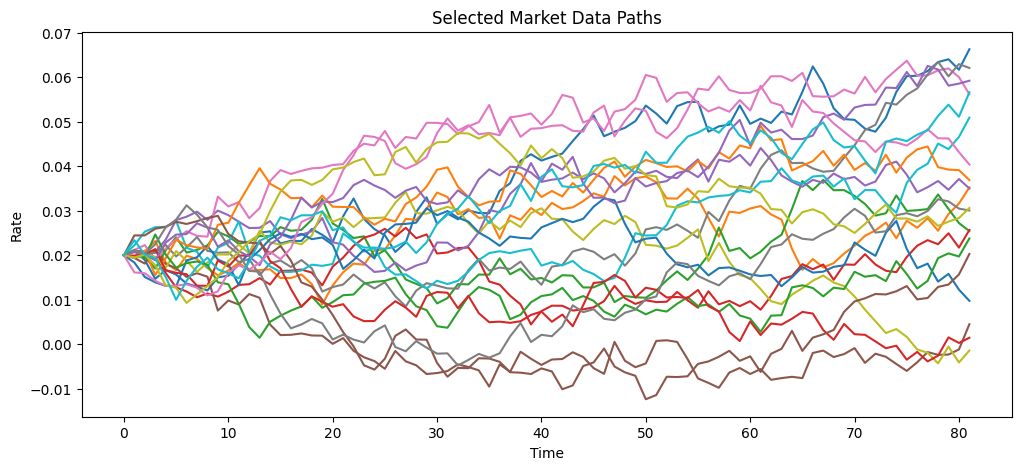

In [3]:
keyNumber = 0 # key 0 corresponds to EONIA, compare to file header
numberOfPaths = 20
# Pick the t0 index fixing and pass it to the plot function below as starting point
analytic = vre.getAnalytic("XVA")
market = analytic.getMarket()
eoniaIndex = market.iborIndex("EUR-EONIA")
fixing = eoniaIndex.fixing(vre.getInputs().asof())
utilities.plotScenarioDataPaths("Output/scenariodata.csv.gz", keyNumber, numberOfPaths, fixing)

dates: 82
samples: 101
depths: 1


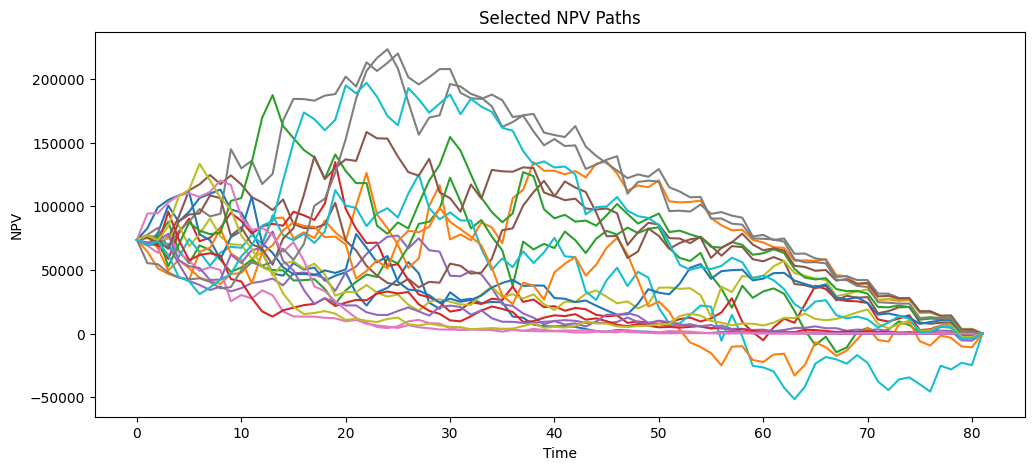

In [4]:
cubeReport = vre.getReport("netcube")
numberOfPaths = 20
utilities.plotNpvPaths(cubeReport, numberOfPaths)

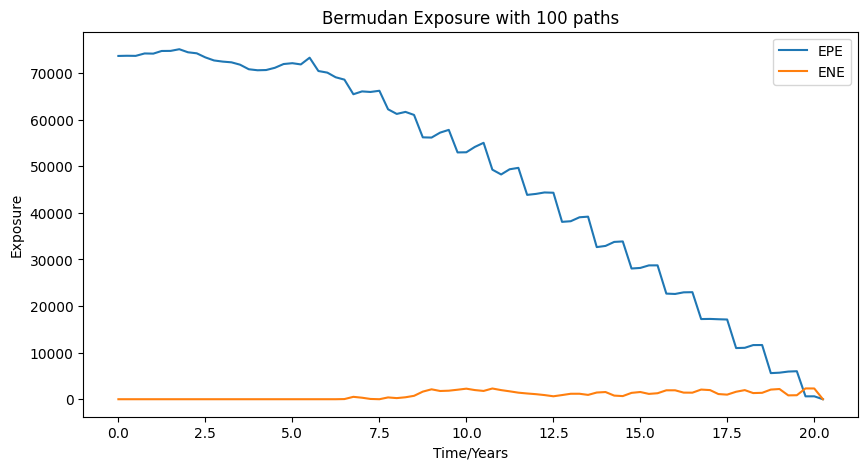

In [5]:
report = vre.getReport("exposure_trade_BermSwp")

time = report.dataAsReal(2)
epe = report.dataAsReal(3);
ene = report.dataAsReal(4);
    
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(nrows=1, ncols=1)
ax0 = fig.add_subplot(gs[0, 0])

ax0.plot(time, epe, label='EPE')
ax0.plot(time, ene, label='ENE')
ax0.set(xlabel='Time/Years')
ax0.set(ylabel='Exposure')
ax0.set_title('Bermudan Exposure with 100 paths')
ax0.legend()

plt.show()

### American Monte Carlo Simulation

Leased Squares or American Monte Carlo algorithm in a nutshell:
- Generate Monte Carlo scenarios of the market evotion as in the classic simulation
- For the backward induction algorithm we then need continuation values on each path (conditional expectations of future values) and at each exercise time
- In the absence of a lattice, the AMC algortihm resorts to the information across paths and computes these conditional expectations via regression
- in VRE we use model states on the paths as regressors and perform linear regressions to determine the polynomial form of the regression fucntions  
- The valuation effort is determined by valuations of the underlying (vanilla) trade, plus the effort of estimating the regression functions and using them to compute conditional expectations
- We do two separate valuation sweeps, a first one for taining and determining the regression functions for each exercise date, a second sweep for the backward induction using the regression functions from sweep 1
- **10000** paths for training and backward induction (vs **100** paths in the classic simulation above)

In [6]:
params_amc = Parameters()
params_amc.fromFile("Input/vre_amc.xml")
vre_amc = VREApp(params_amc, False)
      
vre_amc.run()

utilities.checkErrorsAndRunTime(vre_amc)

Run time: 1.34 sec
Errors: 0


In [7]:
utilities.writeList(vre_amc.getReportNames())


- exposure_trade_BermSwp
- fixings
- runtimes
- npv
- pricingstats
- dividends
- todaysmarketcalibration
- xva
- marketdata
- cva_sensitivity_nettingset_CPTY_A
- exposure_nettingset_CPTY_A
- colva_nettingset_CPTY_A


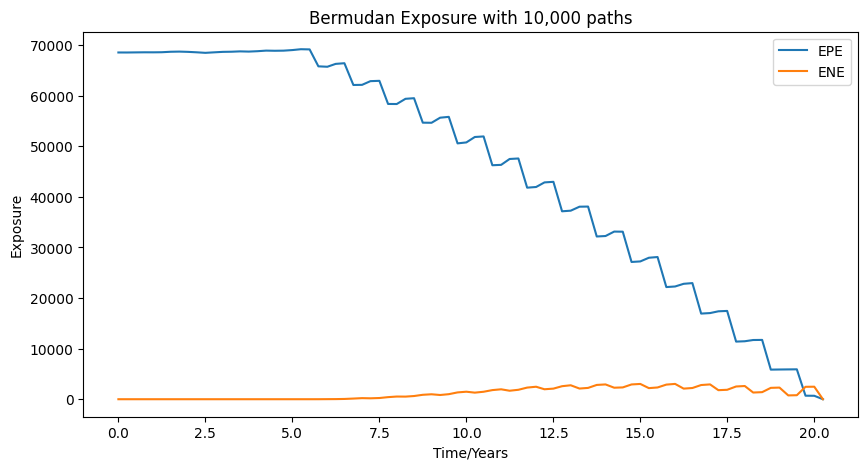

In [8]:
report_amc = vre_amc.getReport("exposure_trade_BermSwp")

time = report_amc.dataAsReal(2)
epe = report_amc.dataAsReal(3);
ene = report_amc.dataAsReal(4);
    
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(nrows=1, ncols=1)
ax0 = fig.add_subplot(gs[0, 0])

ax0.plot(time, epe, label='EPE')
ax0.plot(time, ene, label='ENE')
ax0.set(xlabel='Time/Years')
ax0.set(ylabel='Exposure')
ax0.set_title('Bermudan Exposure with 10,000 paths')
ax0.legend()

plt.show()

## Swap Portfolio Performance: Single vs. multi-threaded

Case
- Portfolio of **50** identical Swaps, 20 year maturity
- **Classic** exposure simulation
- **200 paths** (for moderate single-threaded run time)
- Simulation grid with 80 quarterly steps

### Single Thread

In [9]:
params = Parameters()
params.fromFile("Input/vre_swaps.xml")

vre_swaps = VREApp(params, False)

vre_swaps.run()

utilities.checkErrorsAndRunTime(vre_swaps)

Run time: 6.44 sec
Errors: 0


In [10]:
portfolio = vre_swaps.getInputs().portfolio()
print("trades:", portfolio.size())
inputs = vre_swaps.getInputs()
print ("threads:", inputs.nThreads())

trades: 50
threads: 1


### Multiple Threads

VRE is based on QuantLib which is not thread-safe. Nevertheless, it is possible in VRE to parallelise the processing and utilise the available CPU cores (if you configure the VRE build with QL_ENABLE_SESSIONS=ON). 

All scenario-based risk analytics in VRE such as 
- Sensitivity analysis
- Historical simulation
- Monte Carlo simulation 

use a central ValuationEngine object which loops over scenarios, dates and trades and then applies pricing and cashflow analytics. The multi-threaded version of the ValuationEngine spawns threads, provides each thread with a **part of the portfolio** and its **own market objects**. The markets are built from scratch for each thread which causes some overhead. We plan to clone market objects instead to reduce the overhead. 

The threads then operate on completely separate objects, much like separate processes, because of QuantLib's inherent "thread-unsafety". Because of the overhead it is essential that each thread has a sufficiently sized or complex portfolio and sufficient number of scenarios to process, in order to see a multi-threading benefit. 

We demonstrate the benefit of multi-threading by running again with 4 threads:

In [11]:
inputs.setThreads(4)
print ("threads:", inputs.nThreads())

threads: 4


In [12]:
vre_swaps.run()
utilities.checkErrorsAndRunTime(vre_swaps)

Run time: 4.64 sec
Errors: 0


## Bermudan Swaption Portfolio Performance: Single vs. multi-threaded

Case
- Portfolio of **20** identical Bermudan Swaptions
- **AMC** exposure simulation
- **10,000 paths**
- Simulation grid with 80 quarterly steps

In [13]:
params = Parameters()
params.fromFile("Input/vre_bermudans.xml")

vre_bermudans = VREApp(params, False)

vre_bermudans.run()

utilities.checkErrorsAndRunTime(vre_bermudans)

Run time: 6.00 sec
Errors: 0


In [14]:
portfolio = vre_bermudans.getInputs().portfolio()
print("trades:", portfolio.size())
inputs = vre_bermudans.getInputs()
print ("threads:", inputs.nThreads())

trades: 12
threads: 1


In [15]:
inputs.setThreads(4)
print ("threads:", inputs.nThreads())

threads: 4


In [16]:
vre_bermudans.run()
utilities.checkErrorsAndRunTime(vre_bermudans)

Run time: 3.14 sec
Errors: 0
